<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Add-an-equation-for-the-vapor-mixing-ratio" data-toc-modified-id="Add-an-equation-for-the-vapor-mixing-ratio-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Add an equation for the vapor mixing ratio</a></span></li><li><span><a href="#get-the-flux-profiles-and-the-cloud-thickness" data-toc-modified-id="get-the-flux-profiles-and-the-cloud-thickness-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>get the flux profiles and the cloud thickness</a></span></li><li><span><a href="#Dump-the-result-in-an-hdf-file" data-toc-modified-id="Dump-the-result-in-an-hdf-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dump the result in an hdf file</a></span></li></ul></div>

### Add an equation for the vapor mixing ratio

In [1]:
def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

#
# helper function to turn a dictionary into a named tuple
#
from collections import namedtuple
def make_tuple(tupname,in_dict):
    the_tup = namedtuple(tupname, in_dict.keys())
    the_tup = the_tup(**in_dict)
    return the_tup


In [3]:
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd
from a500.thermlib import thermfuncs as tf



def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    went = -Fint/deltheta  #entrainment velocity (positive upward)
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - coeffs.radcool/1004./the_vars[1]
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

In [4]:
dtout=10.  #minutes
end_time=8*24.   #hours
del_time=dtout*60. #seconds
end_time=end_time*3600. #seconds
sst=297
D=5.e-6  #s-1
U=7  #m/s
psfc=100. #kPa
qsfc=tf.qs_tp(sst,psfc)
ft_intercept = 292 #K
ft_gamma = 6.e-3  #K/m
ft_qv = 2.e-3
k=0.2  #entrainment efficiency
Cd = 1.e-3  #drag coefficient
tspan = np.arange(0.,end_time,del_time)
vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
             qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd,radcool=30.)
the_tup=make_tuple('coeffs',the_tup)
output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])
result['time']=tspan/3600./24.  #days
result['deltheta'] = theta_ft(result['h'].values,ft_intercept,ft_gamma) - result['theta']

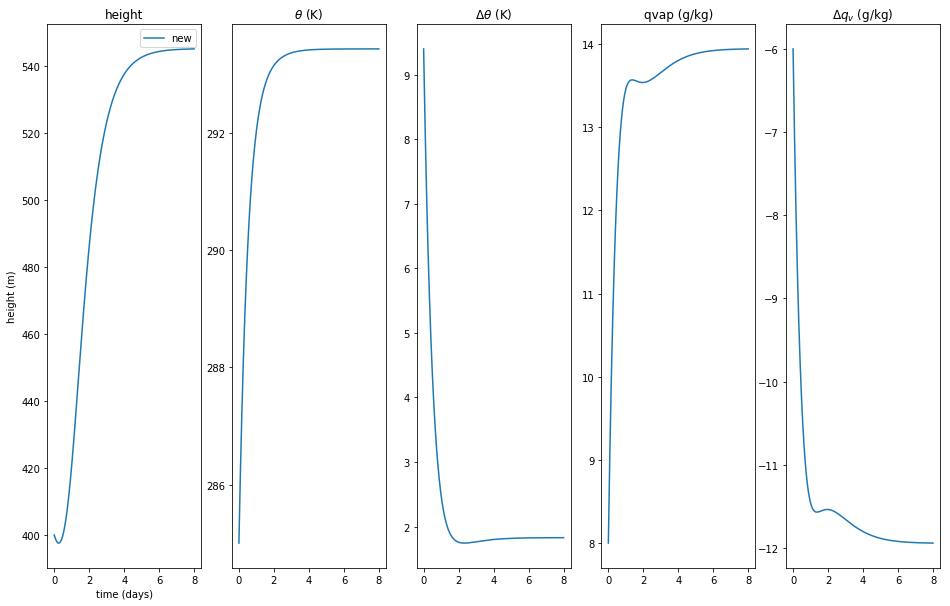

In [5]:
fig,ax = plt.subplots(1,5,figsize=(16,10))
ax[0].plot(result['time'],result['h'],label='new')
ax[0].set(ylabel='height (m)',xlabel='time (days)',title='height')
ax[0].legend(loc='best')
ax[1].plot(result['time'],result['theta'],label='new')
out=ax[1].set(title=r'$\theta$ (K)')
out=ax[2].plot(result['time'],result['deltheta'],label='new')
out=ax[2].set(title=r'$\Delta \theta$ (K)')
out=ax[3].plot(result['time'],result['qv']*1.e3,label='new')
out=ax[3].set(title='qvap (g/kg)')
result['delqv'] = ft_qv - result['qv']
out=ax[4].plot(result['time'],result['delqv']*1.e3)
out=ax[4].set(title=r'$\Delta q_v$ (g/kg)')

### get the flux profiles and the cloud thickness

the next cell applies the calc_lcl function to every row in the dataframe and
adds it as a new column

In [7]:
def calc_lcl(row,psfc):
    """
      find the lcl (in m) for a row in the dataframe
    """
    Tdew = tf.tmr(row['qv'],psfc)
    LCL = tf.LCL(Tdew,row['theta'],psfc)  #kPa
    #
    # rough approximation:  10 kPa = 1 km
    #
    delp=psfc - LCL
    lcl_h = delp*100.
    return lcl_h


def calc_sfc_theta_flux(row,coeffs):
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - row['theta'])  #surface heat flux
    return F0

def calc_sfc_qvap_flux(row,coeffs):
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - row['qv'])
    return Fqv0

def calc_entflux_theta(row,coeffs):
    flux_ent = -coeffs.k*row['T_flux_0']
    return flux_ent

def calc_went(row,coeffs):
    went = -row['entflux_theta']/row['deltheta']
    return went
    
def calc_entflux_qv(row,coeffs):
    flux_ent =  -row['went']*( coeffs.ft_qv - row['qv'])
    return flux_ent


result['LCL']=result.apply(calc_lcl,axis=1,args=(psfc,))
result['q_flux_0']=result.apply(calc_sfc_qvap_flux,axis=1,args=(the_tup,))
result['T_flux_0']=result.apply(calc_sfc_theta_flux,axis=1,args=(the_tup,))  
result['thick'] = result['h'] - result['LCL']
result['entflux_theta']=result.apply(calc_entflux_theta,axis=1,args=(the_tup,))
result['went'] = result.apply(calc_went,axis=1,args=(the_tup,))
result['entflux_qv']=result.apply(calc_entflux_qv,axis=1,args=(the_tup,))
cooling = np.empty_like(result['time'].values)
cooling[:] = the_tup.radcool
result['radcool']  = cooling

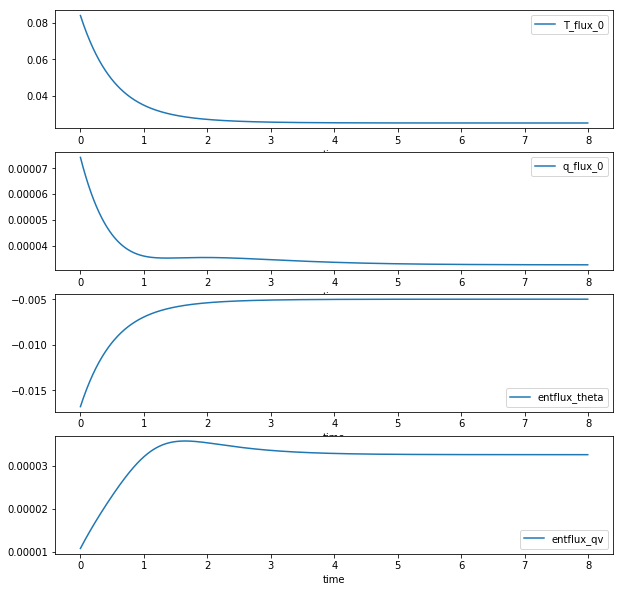

In [8]:
fig,ax=plt.subplots(4,1,figsize=(10,10))
result.plot('time','T_flux_0',ax=ax[0])
result.plot('time','q_flux_0',ax=ax[1])
result.plot('time','entflux_theta',ax=ax[2])
out=result.plot('time','entflux_qv',ax=ax[3])